In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import accuracy_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

Import dataset

In [3]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [4]:
#Store the Id in a dataframe for submission
test_ids = test['Id']

#Pop (remove and stoare) the target in a variable
y = train.pop('Class')

In [5]:
#Remove the Id from train and test
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [6]:
# Impute missing values in numerical columns with median
numerical_cols = train.select_dtypes(include='number').columns
imputer = SimpleImputer(strategy='median')
train[numerical_cols] = imputer.fit_transform(train[numerical_cols])
test[numerical_cols] = imputer.transform(test[numerical_cols])

In [7]:
# One-hot encode the categorical column 'EJ'
categorical_cols = ['EJ']
encoder = OneHotEncoder(sparse=False, drop='first')
ej_encoded_train = encoder.fit_transform(train[categorical_cols])
ej_encoded_test = encoder.transform(test[categorical_cols])

In [8]:
# Create a DataFrame from the encoded EJ data and add column names
ej_encoded_train_df = pd.DataFrame(ej_encoded_train, columns=encoder.get_feature_names_out(categorical_cols))
ej_encoded_test_df = pd.DataFrame(ej_encoded_test, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the encoded EJ data with the rest of the features
train_encoded = pd.concat([train.drop(columns=categorical_cols), ej_encoded_train_df], axis=1)
test_encoded = pd.concat([test.drop(columns=categorical_cols), ej_encoded_test_df], axis=1)

In [9]:
train_encoded

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_B
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1.0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,1.0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,1.0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,1.0
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0.0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,1.0


In [10]:
#state the random to a value
state= 0

In [13]:
# The 'preprocessing' module in scikit-learn provides several functions to preprocess data before model training
from sklearn import preprocessing

In [11]:
#define the X as final encoded train dataframe
X = train_encoded

In [14]:
# Creating an instance of the MinMaxScaler class
min_max_scaler = preprocessing.MinMaxScaler()
# Applying the scaling operation to 'X' using the 'fit_transform' method of MinMaxScaler.
# The 'fit_transform' method computes the minimum and maximum values of each feature in 'X' and then scales the data accordingly.
# It returns the scaled data in 'X_scale'.
X_scale = min_max_scaler.fit_transform(X)

In [15]:
X_scale

array([[0.02108222, 0.10234705, 0.        , ..., 0.36226145, 0.0054245 ,
        1.        ],
       [0.01054111, 0.02758921, 0.        , ..., 0.16413472, 1.        ,
        0.        ],
       [0.0639494 , 0.08571547, 0.        , ..., 0.18021841, 0.00890991,
        1.        ],
       ...,
       [0.056922  , 0.0795391 , 0.02462484, ..., 0.62356058, 1.        ,
        0.        ],
       [0.04638089, 0.03758272, 0.        , ..., 0.1905309 , 0.00834934,
        1.        ],
       [0.06605762, 0.08702893, 0.25286753, ..., 0.59877277, 1.        ,
        0.        ]])

Split dataset: val_and_test size will be 30% of the overall dataset. The code will store the split data into the first four variables on the left of the equal sign as the variable names suggest.

In [16]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, y, test_size=0.3)

Unfortunately, this function only helps us split our dataset into two. Since we want a separate validation set and test set, we can use the same function to do the split again on val_and_test. 

In [17]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

After the secound split the val_and_test size equally to the validation set and the test set.

In [18]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(431, 56) (93, 56) (93, 56) (431,) (93,) (93,)


In [19]:
#import the necessary code from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

**Baseline Neural Network model**

Creating a sequential model using the Keras 'Sequential' API.
The sequential model is a linear stack of layers, where each layer has exactly one input tensor and one output tensor.
'Dense' layers are fully connected layers, and they are suitable for this type of architecture.
The input shape of the first layer is specified as (56,) which means each input sample has 56 features.
The 'activation' argument specifies the activation function to be used for each layer.
'relu' stands for Rectified Linear Unit, which is commonly used in hidden layers for better training.
The model architecture consists of three hidden layers, each with 1000 neurons, followed by an output layer with one neuron.
The output layer uses the 'sigmoid' activation function as it's a binary classification problem.

The 'compile' method is used to configure the model for training.
For optimization, 'sgd' stands for stochastic gradient descent.
Stochastic gradient descent is a common optimization algorithm used to update the model weights during training.
'binary_crossentropy' is the loss function used for binary classification problems.
It measures the difference between the true target values and the predicted target values.
The 'metrics' argument specifies the evaluation metric(s) to be monitored during training.
In this case, I used 'accuracy' to monitor the accuracy of the model on the validation set.

The 'fit' method is used to train the model on the training data.
'X_train' and 'Y_train' are the training data and corresponding target values (labels).
'batch_size' determines the number of samples to use in each update of the model weights.
'epochs' is the number of times the model will iterate over the entire training dataset.
'validation_data' is used to evaluate the model's performance on the validation data during training.
The 'fit' method returns a 'history' object that contains information about the training process.


In [31]:
model_0 = Sequential([
    Dense(1000, activation='relu', input_shape=(56,)),
    Dense(1000, activation='relu', ),
    Dense(1000, activation='relu', ),
    Dense(1, activation='sigmoid'),
])

model_0.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
hist_0 = model_0.fit(X_train, Y_train,
          batch_size=15, epochs=20,
          validation_data=(X_val, Y_val))

Epoch 1/20
29/29 [==============================] - 1s 20ms/step - loss: 0.6456 - accuracy: 0.7517 - val_loss: 0.6087 - val_accuracy: 0.7742
Epoch 2/20
29/29 [==============================] - 0s 13ms/step - loss: 0.5591 - accuracy: 0.8213 - val_loss: 0.5610 - val_accuracy: 0.7742
Epoch 3/20
29/29 [==============================] - 0s 14ms/step - loss: 0.5113 - accuracy: 0.8213 - val_loss: 0.5405 - val_accuracy: 0.7742
Epoch 4/20
29/29 [==============================] - 0s 15ms/step - loss: 0.4874 - accuracy: 0.8213 - val_loss: 0.5339 - val_accuracy: 0.7742
Epoch 5/20
29/29 [==============================] - 0s 13ms/step - loss: 0.4756 - accuracy: 0.8213 - val_loss: 0.5325 - val_accuracy: 0.7742
Epoch 6/20
29/29 [==============================] - 0s 14ms/step - loss: 0.4698 - accuracy: 0.8213 - val_loss: 0.5321 - val_accuracy: 0.7742
Epoch 7/20
29/29 [==============================] - 0s 15ms/step - loss: 0.4662 - accuracy: 0.8213 - val_loss: 0.5318 - val_accuracy: 0.7742
Epoch 8/20
29

In [32]:
model_0.evaluate(X_train, Y_train)[1]

14/14 [==============================] - 0s 6ms/step - loss: 0.4321 - accuracy: 0.8213


0.8213456869125366

In [33]:
model_0.evaluate(X_test, Y_test)[1]

3/3 [==============================] - 0s 7ms/step - loss: 0.3449 - accuracy: 0.8925


0.8924731016159058

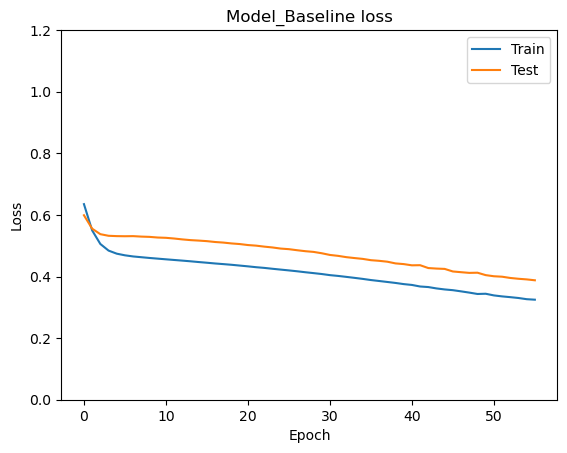

In [29]:
plt.plot(hist_0.history['loss'])
plt.plot(hist_0.history['val_loss'])
plt.title('Model_Baseline loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

In [30]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              57000     
                                                                 
 dense_9 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_10 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_11 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 2,060,001
Trainable params: 2,060,001
Non-trainable params: 0
_________________________________________________________________


**Optimized Neuronal Network Model**

In the optimized version of the Neural Netwrok I introduced:
* 'kernel_regularizer'
* 'Dropout' 
* 'adam' optimization

The 'kernel_regularizer' argument is used to apply L2 regularization to the layer's kernel (weights).
L2 regularization helps prevent overfitting by penalizing large weights in the model.

The 'Dropout' layers are used to introduce dropout regularization.
Dropout randomly sets a fraction of input units to 0 during training, which helps reduce overfitting.

The model architecture consists of four hidden layers, each with 1000 neurons and dropout regularization.
The output layer uses the 'sigmoid' activation function as it's a binary classification problem.

For optimization, 'adam' is an adaptive learning rate optimization algorithm.
It's well-suited for many optimization problems and often performs well in practice.

In [62]:
model = Sequential([
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(56,)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
hist = model.fit(X_train, Y_train,
          batch_size=15, epochs=20,
          validation_data=(X_val, Y_val))

Epoch 1/20
29/29 [==============================] - 3s 39ms/step - loss: 2.5564 - accuracy: 0.8353 - val_loss: 1.7065 - val_accuracy: 0.7957
Epoch 2/20
29/29 [==============================] - 1s 31ms/step - loss: 1.2953 - accuracy: 0.8353 - val_loss: 0.9831 - val_accuracy: 0.8387
Epoch 3/20
29/29 [==============================] - 1s 31ms/step - loss: 0.8448 - accuracy: 0.8585 - val_loss: 0.7008 - val_accuracy: 0.8817
Epoch 4/20
29/29 [==============================] - 1s 30ms/step - loss: 0.6745 - accuracy: 0.8886 - val_loss: 0.6127 - val_accuracy: 0.8387
Epoch 5/20
29/29 [==============================] - 1s 29ms/step - loss: 0.5412 - accuracy: 0.8979 - val_loss: 0.4474 - val_accuracy: 0.9247
Epoch 6/20
29/29 [==============================] - 1s 30ms/step - loss: 0.4641 - accuracy: 0.9072 - val_loss: 0.4412 - val_accuracy: 0.9032
Epoch 7/20
29/29 [==============================] - 1s 30ms/step - loss: 0.4175 - accuracy: 0.9095 - val_loss: 0.3731 - val_accuracy: 0.9355
Epoch 8/20
29

In [63]:
model.evaluate(X_train, Y_train)[1]

14/14 [==============================] - 0s 9ms/step - loss: 0.2153 - accuracy: 0.9582


0.9582366347312927

In [64]:
model.evaluate(X_test, Y_test)[1]

3/3 [==============================] - 0s 8ms/step - loss: 0.4008 - accuracy: 0.8495


0.8494623899459839

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1000)              57000     
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_16 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_8 (Dropout)         (None, 1000)              0         
                                                                 
 dense_17 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_9 (Dropout)         (None, 1000)              0         
                                                                 
 dense_18 (Dense)            (None, 1000)             

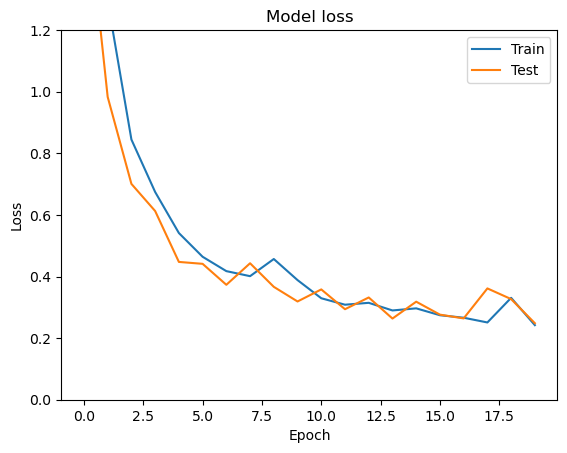

In [68]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

In [ ]:
raw_predictions = model.predict(test_encoded)

In [ ]:
from scipy.special import softmax

In [ ]:
# The softmax values for each row/element represent the probabilities for each class, and they sum up to 1.
probabilities = softmax(raw_predictions, axis=-1)

# Extract the column of probabilities for class 0
p0 = probabilities[:, :1]

# Threshold the probabilities to assign class labels
p0[p0 > 0.74] = 1  # Assign values above 0.74 as class 1
p0[p0 < 0.26] = 0  # Assign values below 0.26 as class 0


In [ ]:
submission = pd.DataFrame({'Id': test_ids})
submission

In [ ]:
# Add the 'class_0' column containing the thresholded predictions for class 0
submission["class_0"] = p0

# Add the 'class_1' column containing the complement of the thresholded predictions for class 0
submission["class_1"] = 1 - p0

# Save the submission DataFrame to a CSV file named 'submission.csv' without including the index column
submission.to_csv('submission.csv', index=False)

In [70]:
submission

,Id,class_0,class_1
0,00eed32682bb,1.0,0.0
1,010ebe33f668,1.0,0.0
2,02fa521e1838,1.0,0.0
3,040e15f562a2,1.0,0.0
4,046e85c7cc7f,1.0,0.0
